In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_gender_submission = pd.read_csv('../submission.csv')

In [3]:
data = pd.concat([df, df_test], sort=False)
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
# 男性は0, 女性は1

In [4]:
# # Ageの欠損値をランダムフォレストで補充
# age_df = data[['Age', 'Pclass', 'Sex','Parch', 'SibSp']]
# age_df = pd.get_dummies(age_df)

# age_full = age_df[age_df['Age'].notnull()].values
# age_nan = age_df[age_df['Age'].isnull()].values

# X = age_full[:, 1:]
# y = age_full[:, 0].astype(int)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# param = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth':np.arange(1, 15)}

# model_age = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param)
# model_age.fit(X_train, y_train)
# random_grid = model_age.best_estimator_
# print(random_grid)
# print('ランダムフォレストの予測値:{:.3f}'.format(model_age.score(X_train, y_train)))
# print('ランダムフォレストの予測値:{:.3f}'.format(model_age.score(X_test, y_test)))

In [5]:
# model_age = RandomForestRegressor(random_state=42, n_estimators=88, n_jobs=-1)
# model_age.fit(X, y)

# predict_ages = model_age.predict(age_nan[:, 1:])
# data.loc[(data.Age.isnull()), 'Age'] = predict_ages

In [6]:
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

In [7]:
fare_mean = data.loc[(data['Embarked'] == 'S') & (data['Pclass'] == 3), 'Fare'].median()
data['Fare'] = data['Fare'].fillna(fare_mean)

In [8]:
data[data['Embarked'].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,0.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,830,0.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


In [9]:
S = data[(data['Embarked'] == 'S') & (data['Pclass'] == 1)]['Fare'].median()
C = data[(data['Embarked'] == 'C') & (data['Pclass'] == 1)]['Fare'].median()
Q = data[(data['Embarked'] == 'Q') & (data['Pclass'] == 1)]['Fare'].median()
print(S, C, Q)

52.0 76.7292 90.0


In [10]:
data['Embarked'] = data['Embarked'].fillna('C')

In [11]:
data['Title'] = data['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
pd.Series.unique(data['Title'])

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [12]:
data[data['Title']=='Ms']

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
443,444,0.0,2,"Reynaldo, Ms. Encarnacion",1,28.0,0,0,230434,13.00,NaN,S,Ms
88,980,NaN,3,"O'Donoghue, Ms. Bridget",1,24.0,0,0,364856,7.75,NaN,Q,Ms


<AxesSubplot:xlabel='Title', ylabel='Perished'>

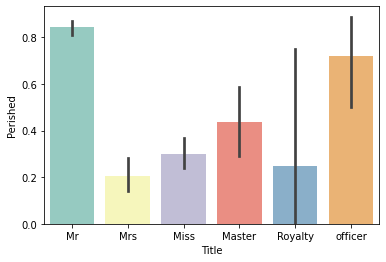

In [13]:
data['Title'].replace({'Capt', 'Col', 'Major', 'Dr', 'Rev'}, 'officer', inplace=True)
data['Title'].replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
data['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
data['Title'].replace(['Mlle'], 'Miss', inplace=True)
data['Title'].replace(['Jonkheer'], 'Master', inplace=True)
# Missは女の子、Masterは男の子らしい
sns.barplot(x='Title', y='Perished', data=data, palette='Set3')

In [14]:
data['Surname'] = data['Name'].map(lambda name: name.split(',')[0].strip())
data['FamilyGroup'] = data['Surname'].map(data['Surname'].value_counts())

In [15]:
Female_Child_Group = data.loc[(data['FamilyGroup']>=2) & ((data['Age']<=18) | (data['Sex']=='1'))]
Female_Child_Group = Female_Child_Group.groupby('Surname')['Perished'].mean()
print(Female_Child_Group.value_counts())

0.000000    42
1.000000    22
0.500000     3
0.833333     1
0.333333     1
Name: Perished, dtype: int64


In [16]:
Male_Adult_Group = data.loc[(data['FamilyGroup']>=2) & ((data['Age']>18) | (data['Sex']=='0'))]
Male_Adult_Group = Male_Adult_Group.groupby('Surname')['Perished'].mean()
print(Male_Adult_Group.value_counts())

1.000000    92
0.000000    63
0.500000    30
0.666667     7
0.333333     4
0.750000     3
0.250000     2
Name: Perished, dtype: int64


In [17]:
Dead_list = set(Female_Child_Group[Female_Child_Group.apply(lambda x: x==1)].index)
print(Dead_list)
Survived_list = set(Male_Adult_Group[Male_Adult_Group.apply(lambda x: x==0)].index)
print(Survived_list)

{'Calic', 'Abbott', 'Vander Planke', 'Elias', 'Klasen', 'Zabour', 'Rosblom', 'Goodwin', 'Boulos', 'Rice', 'Van Impe', 'Attalah', 'Barbara', 'Strom', 'Wiklund', 'Panula', 'Arnold-Franchi', 'Jensen', 'Skoog', 'Ford', 'Palsson', 'Andrew'}
{'Moor', 'Chambers', 'Abbott', 'Caldwell', 'Cumings', 'Fleming', 'Hamalainen', 'Taylor', 'Ryerson', 'Asplund', 'Duff Gordon', 'Nakid', 'Sandstrom', 'Compton', 'Greenfield', 'McCoy', 'Quick', 'Baclini', 'Faunthorpe', 'Doling', 'Nilsson', 'Murphy', 'Phillips', 'Goldenberg', 'Burns', 'Kimball', 'Connolly', 'Frolicher-Stehli', 'Bonnell', 'Daly', 'Louch', 'Herman', 'Bishop', 'Angle', 'Beane', 'Frauenthal', 'Harder', 'Warren', 'Wick', 'Hippach', 'Spedden', 'Dick', 'Hays', 'Richards', 'Duran y More', 'Spencer', 'Cardeza', 'Touma', 'Bradley', 'Christy', 'Clarke', 'Moubarek', 'Mellinger', 'Weisz', 'Peter', 'Davison', 'Jonsson', 'Rothschild', 'Watt', 'Beckwith', 'de Messemaeker', 'Kenyon', 'Drew'}


In [18]:
# 女性・子供グループで全員死亡した名字の人は、典型的な死亡データである70才の男性(0で継承はMrにする。
# 男性グループで全員生存した苗字の日とは5才の女性で、継承はMissにする。
data.loc[(data['Perished'].isnull()) & (data['Surname'].apply(lambda x: x in Dead_list)), ['Sex', 'Age', 'Title']] = ['0', '28.0', 'Mr']
data.loc[(data['Perished'].isnull()) & (data['Surname'].apply(lambda x: x in Survived_list)), ['Sex', 'Age', 'Title']] = ['0', '5.0', 'Mrs']

<AxesSubplot:xlabel='Family', ylabel='Perished'>

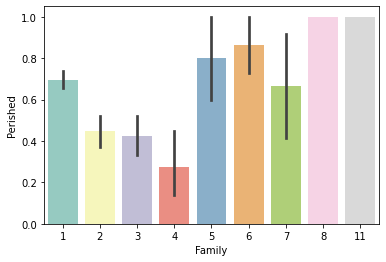

In [19]:
data['Family'] = data['SibSp'] + data['Parch'] + 1
sns.barplot(x='Family', y='Perished', data=data, palette='Set3')

In [20]:
data.loc[(data['Family']>=2) & (data['Family']<=4), 'Family_label'] = 0
data.loc[(data['Family']>=5) & (data['Family']<=7) | (data['Family'] == 1), 'Family_label'] = 1
data.loc[(data['Family'] >= 8), 'Family_label'] = 2

<AxesSubplot:xlabel='TicketGroup', ylabel='Perished'>

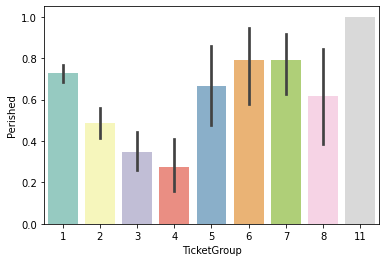

In [21]:
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Perished', data=data, palette='Set3')

In [22]:
data.loc[(data['Family']>=2) & (data['Family']<=4), 'Family_label'] = 0
data.loc[(data['Family']>=5) & (data['Family']<=8) | (data['Family'] == 1), 'Family_label'] = 1
data.loc[(data['Family'] >= 11), 'Family_label'] = 2

In [23]:
data['Cabin'] = data['Cabin'].fillna('Unknown')
data['Cabin_label']=data['Cabin'].str.get(0)

In [24]:
data1 = data[['Perished', 'Pclass', 'Sex', 'Age', 'Fare', 'Family_label', 'TicketGroup']]
data1.head()

,Perished,Pclass,Sex,Age,Fare,Family_label,TicketGroup
0,1.0,3,0,22.0,7.2500,0.0,1
1,0.0,1,1,38.0,71.2833,0.0,2
2,0.0,3,1,26.0,7.9250,1.0,1
3,0.0,1,1,35.0,53.1000,0.0,2
4,1.0,3,0,35.0,8.0500,1.0,1


In [25]:
data2 = pd.get_dummies(data.loc[:, ['Cabin_label', 'Embarked', 'Title']] )
data2.head(5)

,Cabin_label_A,Cabin_label_B,Cabin_label_C,Cabin_label_D,Cabin_label_E,Cabin_label_F,Cabin_label_G,Cabin_label_T,Cabin_label_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty,Title_officer
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [26]:
data = pd.concat([data1, data2], axis=1)

In [27]:
data.head(5)

,Perished,Pclass,Sex,Age,Fare,Family_label,TicketGroup,Cabin_label_A,Cabin_label_B,Cabin_label_C,...,Cabin_label_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty,Title_officer
0,1.0,3,0,22.0,7.2500,0.0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,0.0,1,1,38.0,71.2833,0.0,2,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0.0,3,1,26.0,7.9250,1.0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,0.0,1,1,35.0,53.1000,0.0,2,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,1.0,3,0,35.0,8.0500,1.0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [28]:
print(len(data.columns))
print(data.columns)

25
Index(['Perished', 'Pclass', 'Sex', 'Age', 'Fare', 'Family_label',
       'TicketGroup', 'Cabin_label_A', 'Cabin_label_B', 'Cabin_label_C',
       'Cabin_label_D', 'Cabin_label_E', 'Cabin_label_F', 'Cabin_label_G',
       'Cabin_label_T', 'Cabin_label_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Royalty', 'Title_officer'],
      dtype='object')


In [29]:
train_data = data[data['Perished'].notnull()]
test_data = data[data['Perished'].isnull()].drop('Perished', axis=1)

X = train_data.iloc[:, 1:].values
y = train_data.iloc[:, 0].values
test_data = test_data.iloc[:, 0:].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('select', SelectKBest(k=20)), ('classify', RandomForestClassifier(random_state=42, n_jobs=-1))])
params = {'classify__n_estimators':np.arange(0, 100, 10), 'classify__max_depth':np.arange(1, 15)}

gsearch = GridSearchCV(estimator=pipe, param_grid=params)
gsearch.fit(X, y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 5, 'classify__n_estimators': 80} 0.8338899001945892


In [31]:
select = SelectKBest(k=20)
randomfs = RandomForestClassifier(random_state=42, n_estimators=80, max_depth=5, n_jobs=-1)
pipeline = make_pipeline(select, randomfs)
pipeline.fit(X, y)
print('Train Score: {}'.format(round(pipeline.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(pipeline.score(X_test, y_test), 3)))

Train Score: 0.85
 Test Score: 0.844


In [32]:
y_pred = pipeline.predict(test_data)
y_pred

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0.

In [33]:
df_gender_submission['Perished'] = y_pred
df_gender_submission.head(10)
df_gender_submission.to_csv('../submission.csv', index=False)